In [1]:
import numpy as np
from cosmoTransitions.tunneling1D import SingleFieldInstanton
from cosmoTransitions import generic_potential_Gegenbauer
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc
from scipy.special import gegenbauer
from scipy.special import eval_gegenbauer
from scipy.special import roots_gegenbauer
import math 




%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size

###print out  default colors
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

label_size=20
thick_size=20


####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2

alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
gtab = np.loadtxt( 'standardmodel2018.txt' )[::20]
g_star=interpolate.interp1d(gtab[::,0], gtab[::,1], kind='cubic')
g_sstar=interpolate.interp1d(gtab[::,0], gtab[::,3], kind='cubic')


def Hubble_radiation(T):
    """Hubble rate (squared) coming from radiation dof"""
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return Hubble_rad_squared

def Gamma_Hubble4(S,T):
    """Nucleation probability per Hubble volume, including matter contribution. 
    Integrand in formula (2.2) 1809.08242 """
    Gamma1=T**4*np.exp(-S/T)*np.sqrt((S/2/np.pi/T))**(3)
    return Gamma1


####MY FUNCTIONS START HERE      


def GBpotential(Ngb,n,z):
    lam=(Ngb-1)/2
    x=np.cos(z)
    return eval_gegenbauer(n,lam,x)

def GBpotential_roots(Ngb,n):
    """Return the roots of the Gegenbauer polynomial"""
    lam=(Ngb-1)/2
    output=roots_gegenbauer(n,lam)[0]
    return sorted(np.arccos(output[output>0]))
                 

def findGBminima(Ngb,n,roots_list):
    "Find the all minima of the Gegenbauer polynomial between 0 and pi/2"
    fun=lambda z:GBpotential(Ngb,n,z)
    output=[]
    for i in range(len(roots_list)):
        if 2*i+1==len(roots_list) or 2*i==len(roots_list):
            break
        solmin=optimize.minimize_scalar(fun,bounds=(roots_list[2*i],roots_list[2*i+1]),method="bounded",options={"disp":False})
        output.append(solmin.x)
    return np.array(output)



def kappa(xi_w,alpha):
    """
    Fit for the efficiency factor 
    """
    c_s         = 1./np.sqrt(3.)
    #kappa_A     = xi_w**1.2 * 6.9*alpha/(1.39-0.0037*np.sqrt(alpha)+alpha)
    kappa_A     = xi_w**1.2 * 6.9*alpha/(1.36-0.037*np.sqrt(alpha)+alpha)
    #kappa_B     = alpha**0.4/(0.0017+(0.997+alpha)**0.4)
    kappa_B     = alpha**0.4/(0.017+(0.997+alpha)**0.4)
    #kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98)+alpha)
    kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98+alpha))
    #kappa_D     = alpha/(0.75+0.085*np.sqrt(alpha)+alpha)
    kappa_D     = alpha/(0.73 + 0.083*np.sqrt(alpha)+alpha)
    delta_kappa = -0.9*np.log10(np.sqrt(alpha)/(1.+np.sqrt(alpha)))
    xi_w_J      = (np.sqrt(2./3.*alpha+alpha**2)+1./np.sqrt(3.))/(1.+alpha)

    if xi_w < c_s:
    # deflagration
        return c_s**2.2 * kappa_A * kappa_B / ( (c_s**2.2 - xi_w**2.2 )*kappa_B + xi_w * c_s**1.2 * kappa_A )
    elif xi_w < xi_w_J:
    # hybrid
        return (
            kappa_B
            + (xi_w -c_s)*delta_kappa
            + (xi_w-c_s)**3/(xi_w_J-c_s)**3 * ( kappa_C - kappa_B - (xi_w_J-c_s)*delta_kappa )
        )
    else:
        # detonation
        return (xi_w_J-1.)**3 * (xi_w_J/xi_w)**2.5 * kappa_C * kappa_D /(
            ( (xi_w_J-1.)**3 - (xi_w-1.)**3 ) * xi_w_J**2.5 * kappa_C
            + (xi_w-1.)**3 * kappa_D)



LISA_sens = np.loadtxt( 'PLS_ESACallv1-2_04yr.txt' )[::20]
BBO_sens=pd.read_csv("BBO_integrated_curve.csv",index_col=[0])
def GW_signal_old(Temp,alpha,beta,vel):
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta ##eqn. (7.5)
    f_sw=2.6*1e-5/HR*(Temp/100)*(g_star(Temp)/100)**(1/6) ##eqn. (7.3)
    Sw = lambda f: (f/f_sw)**3*(4/7 + 3/7*(f/f_sw)**2)**(-7/2) ##eqn. (7.2)
    Uf=np.sqrt(3/4*alpha/(1+alpha)*kappa(vel,alpha))##eqn. (7.4)
    tauH = HR/Uf ##eqn. (7.4)
    prefactor=4.13*1e-7*HR*(1-1/np.sqrt(1+2*tauH))*(kappa(vel,alpha)*alpha/(1+alpha))**2 ##eqn. (7.1)
    Omega=lambda f: prefactor*(100/g_star(Temp))**(1/3)*Sw(f) ##eqn. (7.1)
    #f_range=LISA_sens[::,0]
    f_range=np.logspace(-10,4,500)
    GW_tab=[Omega(f) for f in f_range]
    return np.array([list(f_range), list(GW_tab)])

def GW_signal(Temp,alpha,beta,vel,gdof):
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta ##eqn. (7.5)
    f_sw=2.6*1e-5/HR*(Temp/100)*(gdof/100)**(1/6) ##eqn. (7.3)
    Sw = lambda f: (f/f_sw)**3*(4/7 + 3/7*(f/f_sw)**2)**(-7/2) ##eqn. (7.2)
    Uf=np.sqrt(3/4*alpha/(1+alpha)*kappa(vel,alpha))##eqn. (7.4)
    tauH = HR/Uf ##eqn. (7.4)
    prefactor=4.13*1e-7*HR*(1-1/np.sqrt(1+2*tauH))*(kappa(vel,alpha)*alpha/(1+alpha))**2 ##eqn. (7.1)
    Omega=lambda f: prefactor*(100/gdof)**(1/3)*Sw(f) ##eqn. (7.1)
    #f_range=LISA_sens[::,0]
    f_range=np.logspace(-10,4,500)
    GW_tab=[Omega(f) for f in f_range]
    return np.array([list(f_range), list(GW_tab)])


def SNR_GW(signal):
    """Computes SNR given signal (f,Omega)"""
    time=4
    f,Om=signal
    OmGW=interpolate.interp1d(f,Om, kind='cubic')
    Om=OmGW(LISA_sens[::,0])
    On=LISA_sens[::,3]
    integral=integrate.simps(Om**2/On**2,LISA_sens[::,0])
    SNR_val=(time*3.15*10**7*integral)**0.5

    return SNR_val


def epsilon_bound(f,Mscale,n,Ngb):
    epsilon_max=24*f**2/Mscale**2*16*np.pi**2*Ngb/3
    epsilon_max*=math.factorial(Ngb)
    epsilon_max*=math.factorial(n-1)
    epsilon_max*=1/math.factorial(n+Ngb-1)
    epsilon_max*=1/n
    epsilon_max*=1/(Ngb-1)
    epsilon_max*=1/(Ngb + n - 1)
    return epsilon_max
    
        
def epsilon_boundT(f,Mscale,n,Ngb):
    epsilon_max=24*f**2/Mscale**2
    epsilon_max*=math.factorial(Ngb)
    epsilon_max*=math.factorial(n-1)
    epsilon_max*=1/math.factorial(n+Ngb-1)
    epsilon_max*=1/n
    epsilon_max*=1/(Ngb-1)
    epsilon_max*=1/(Ngb + n - 1)
    return epsilon_max

def finite_diff(fun,x0,dx):
    """This function compute the derivative of f(x) at x0 using finite diff with step dx"""
    dfdx = fun(x0-2*dx)
    dfdx -= 8*fun(x0-dx)  
    dfdx +=8*fun(x0+dx)  
    dfdx -= fun(x0+2*dx)  
    dfdx *= 1./(12*dx)
    return dfdx


###Plot JB(x) function
#from cosmoTransitions.finiteT import Jb_spline as Jb
#xrange=np.linspace(-100,100,200)
#plt.plot(xrange,Jb(xrange))

In [2]:
##Plot a gegenbayer polynomial 
#z_range=np.linspace(np.pi/10,np.pi/2,100)
#roots=GBpotential_roots(Ngb=5,n=10)
#min_list=findGBminima(5,10,roots)
#plt.plot(z_range,GBpotential(5,10,z_range))
#plt.scatter(min_list,GBpotential(5,10,min_list))


In [3]:
class model1(generic_potential_Gegenbauer.generic_potential):

    def init(self, N , n , f, eps, xi):
        self.Ndim = 1
        ##Free parameters
        self.N=N
        self.n=n
        self.f=f
        self.eps=eps
        self.Tf=np.sqrt(24/(self.n*(self.n+self.N-1)))*self.f
        self.Tv=self.Tf*xi ##Temperature of the visible sector

        roots=GBpotential_roots(self.N,self.n)
        min_list=np.array(findGBminima(self.N,self.n,roots))*self.f
        self.vacua_list=min_list
        self.renormScaleSq = self.f**2
        
        ##Here I am not sure
        self.Trestored=None
        self.phases=None
        self.Tc=None
        self.df_nuc=None

 
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h = X[...]
        z=h/self.f
        Mscale=4*np.pi*self.f
        pot =self.eps*self.f**2*Mscale**2*GBpotential(self.N,self.n,z)
        return pot
    
            
    
    def boson_massSq(self, X, T):
        X = np.asanyarray(X)
        h = X[...,]
        
        lam=(self.N-1)/2.
        x=h/self.f
        Mscale=4*np.pi*self.f
        
        Mh2=-np.cos(x)*eval_gegenbauer(self.n-1,lam+1,np.cos(x))
        Mh2+=2*(1+lam)*eval_gegenbauer(self.n-2,lam+2,np.cos(x))*np.sin(x)**2
        Mh2*=2*Mscale**2*self.eps*lam
        
        MG2=-2*Mscale**2*self.eps*lam*np.cos(x)*eval_gegenbauer(self.n-1,lam+1,np.cos(x))
        
        M = np.array([Mh2,MG2])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1,self.N-1])

        c = np.array([.5,.5])

        return M, dof, c
    
    def fermion_massSq(self, X):
        X = np.asanyarray(X)
        h = X[...,]

        mt=1**2*h**2/2
        M = np.array([mt])

        M = np.rollaxis(M, 0, len(M.shape))

        dof = 0*np.array([12])
        return M, dof

    def approxZeroTMin(self):
        return list(self.vacua_list)
    
    def plot1(self):
        """Plot the tree-level potential"""
        z_range=np.linspace(0,self.f*np.pi/2,200)

        plt.plot(z_range,self.V0(z_range),label="Tree-level")
        if len(self.vacua_list)==0:
            self.findVacua_list()
        plt.scatter(self.vacua_list,self.V0(self.vacua_list))

        plt.xlabel("$\Pi$ [GeV]",size=label_size)
        plt.ylabel("$G$",size=label_size)
        plt.legend()
        plt.legend(prop={'size': label_size})
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        #mytitle=str(round(df_full.lams.min(),2))+"$< \\lambda_{s} <$"+str(round(df_full.lams.max(),2))
        #plt.title(mytitle,size=label_size)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
        
        
    def findTrestoration(self):
        """Find temperature of symmetry restoration"""
        T_range=np.linspace(self.Tf+100,self.Tf-10,200)
        for Temp in T_range:
            h0=self.findMinimum(0,Temp)
            h1=self.findMinimum(300,Temp)
            if abs(abs(h0)-abs(h1))>10 and self.Vtot(abs(h0),Temp)<self.Vtot(abs(h1),Temp):
                self.Trestored=Temp
                return Temp
    def minTracker(self):
        """Method to track the phases. It stores the output in a dictionary and saves it into
        self.phases"""
        phases_dict={"phase_0":{"phi":[],"T":[]},"phase_1":{"phi":[],"T":[]}}
        if self.Trestored==None:
            self.findTrestoration()
        T_range=np.linspace(self.Trestored,self.Trestored-100,1000)
        for Temp in T_range:
            h1=self.findMinimum(1,Temp)[0]
            hguess=self.vacua_list[0] ##We should aim to improve this method 
            h2=self.findMinimum(hguess,Temp)[0]
            if abs(h1-h2)>10 and h1<h2:
                phases_dict["phase_0"]["phi"].append(h1)
                phases_dict["phase_0"]["T"].append(Temp)
                phases_dict["phase_1"]["phi"].append(h2)
                phases_dict["phase_1"]["T"].append(Temp)
            #elif h1>100:
            #    phases_dict["phase_1"]["phi"].append(h2)
            #    phases_dict["phase_1"]["T"].append(Temp)
            #else:
            #    phases_dict["phase_0"]["phi"].append(h1)
            #    phases_dict["phase_0"]["T"].append(Temp)
            else:
                continue
        self.phases=phases_dict
        return phases_dict
    
    def findTcritical(self):
        """Find the critial temperature once the phase history is known"""
        if self.phases==None:
            phase_output=self.minTracker()
        else:
            phase_output=self.phases
        phase0_T=interpolate.interp1d(phase_output["phase_0"]["T"], phase_output["phase_0"]["phi"])
        phase1_T=interpolate.interp1d(phase_output["phase_1"]["T"], phase_output["phase_1"]["phi"])
        T_range=np.linspace(max(phase_output["phase_1"]["T"]),min(phase_output["phase_0"]["T"]))
        DVfun=lambda T: abs(self.Vtot(abs(phase0_T(T)),T)-self.Vtot(abs(phase1_T(T)),T))
        Tcritical=optimize.minimize_scalar(DVfun,bounds=(min(phase_output["phase_0"]["T"]),max(phase_output["phase_1"]["T"])),method="bounded",options={"disp":False})
        self.Tc=Tcritical.x
        
        #plt.plot(phase_output["phase_0"]["T"],phase0_T(phase_output["phase_0"]["T"]),label="High phase")
        #plt.plot(phase_output["phase_1"]["T"],phase1_T(phase_output["phase_1"]["T"]),label="Low phase")
        #plt.legend(prop={'size': label_size})
        #plt.xlabel("$T$ [GeV]",size=label_size)
        #plt.ylabel("$\\phi$",size=label_size)
        #plt.xticks(fontsize=thick_size)
        #plt.yticks(fontsize=thick_size)
        #plt.grid(True)
        #mytitle="phase history"
        #plt.title(mytitle,size=label_size)
        #plt.tight_layout()
        
    def nucleation(self,Temp):
        """compute the instanton and return a dictionary with several thermodynamic variables"""
        if self.phases==None:
            phase_output=self.minTracker()
            self.findTcritical()
        else:
            phase_output=self.phases
        #phase0_T=interpolate.interp1d(phase_output["phase_0"]["T"], phase_output["phase_0"]["phi"])
        #phase1_T=interpolate.interp1d(phase_output["phase_1"]["T"], phase_output["phase_1"]["phi"])
        ##Only care about T <=Tc
        ind=np.where(np.array(phase_output["phase_0"]["T"])<=self.Tc)
        phase0_T=interpolate.interp1d(np.array(phase_output["phase_0"]["T"])[ind],np.array(phase_output["phase_0"]["phi"])[ind])
        ind=np.where(np.array(phase_output["phase_1"]["T"])<=self.Tc)
        phase1_T=interpolate.interp1d(np.array(phase_output["phase_1"]["T"])[ind],np.array(phase_output["phase_1"]["phi"])[ind])

        
        phi_false= self.findMinimum(phase0_T(Temp),Temp)[0] 
        phi_true=self.findMinimum(phase1_T(Temp),Temp)[0]  
        pot_fun=lambda h : self.Vtot(h,Temp)
        
        if phi_false>phi_true or (phi_true-phi_false)<10 or pot_fun(phi_true)>pot_fun(phi_false):
            return 
        
        #VT_false=lambda T : self.Vtot(phi_false,T)
        #DVT_false=misc.derivative(VT_false, x0=Temp, dx=1e-1, n=1)
        #VT_true=lambda T : self.Vtot(phi_true,T)
        #DVT_true=misc.derivative(VT_true, x0=Temp, dx=1e-1, n=1)
        #rho_r= g_star(Temp)*np.pi**2/30*Temp**4
        #alpha_strength=(self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp)-Temp/4*(DVT_false-DVT_true))/rho_r
        rho_r=self.N*np.pi**2/30*Temp**4
        alpha_strength=(self.energyDensity(phi_false,Temp)-self.energyDensity(phi_true,Temp))/rho_r
        vwall=np.sqrt((self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp))/alpha_strength/rho_r)
        vJ=1/3**.5*(1+np.sqrt(3*alpha_strength**2+2*alpha_strength))/(1+alpha_strength)
        if vwall>=vJ:
            vwall=1

        instanton=SingleFieldInstanton(phi_true, phi_false, pot_fun)
        phi_profile=instanton.findProfile()
        S_3=instanton.findAction(phi_profile)
        #Hubble1=Hubble_radiation(Temp)
        Hubble1=np.pi**2/90/Mplanck**2*(self.N*Temp**4 + g_star(self.Tv)*self.Tv**4)
        Hubble2=((self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp))/3/Mplanck**2)
        Hubble=Hubble1+Hubble2
        Gamma_rate=Gamma_Hubble4(S_3,Temp)
        nuc_output={"phi_false":phi_false,"phi_true":phi_true,"Tn":Temp,"Gamma":Gamma_rate,"S_3":S_3,
                    "Hubble1":Hubble1,"Hubble2":Hubble2,
                    "alpha":alpha_strength,"vw":vwall,"vJ":vJ}
        return nuc_output 
        
    def thermodynamics(self):
        """This method does the whole pipeline
        0. Find phase history
        1. computes the vacuum tunneling
        2. Extract thermodynamic parameters
        3. Computes GW signal
        """
        if self.phases==None:
            phase_output=self.minTracker()
        else:
            phase_output=self.phases
        Tmin=min(self.phases["phase_0"]["T"])
        self.findTcritical()
        nucleation_list=[]
        for temp in np.linspace(Tmin,self.Tc):
            try:
                nuc_output=self.nucleation(temp)
                if len(nuc_output)!=0:
                    nucleation_list.append(nuc_output)
            except:
                continue
        #df_nuc=pd.DataFrame(nucleation_list).dropna()
        df_nuc=pd.DataFrame(nucleation_list)
        self.df_nuc=df_nuc
        
        N_nuc=interpolate.interp1d(df_nuc["Tn"],(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2/df_nuc["Gamma"]-1)
        Tnuc=optimize.root_scalar(N_nuc,bracket=(df_nuc["Tn"].min(),df_nuc["Tn"].max())).root
        S_T_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"])
        #beta=Tnuc*misc.derivative(S_T_inter, x0=Tnuc, dx=1e-0, n=1)
        beta=Tnuc*finite_diff(S_T_inter,Tnuc,(self.Tc-Tnuc)/Tnuc)
        alpha_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["alpha"])
        vel_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["vw"])
        phi_false_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["phi_false"])
        phi_true_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["phi_true"])
        gdof=self.N + g_star(self.Tv)/(Tnuc/self.Tv)**4
        
        al,beta,vel=alpha_inter(Tnuc),beta,vel_inter(Tnuc)
        my_signal=GW_signal(Tnuc,al,beta,vel,gdof)
        SNR_signal=SNR_GW(my_signal)
        dict_out={"Ngb":self.N,"n":self.n,"epsilon":self.eps,"f":self.f,
                  "Tf":self.Tf,"Trestored":self.Trestored,"Tc":self.Tc,
                 "phi_false":phi_false_inter(Tnuc).item(),"phi_true":phi_true_inter(Tnuc).item(),
                 "Tn":Tnuc,"alpha":al.item(),"beta":beta,"vw":vel.item(),"SNR":SNR_signal,
                  "xi_0":self.Tf/self.Tv,"xi_nuc":Tnuc/self.Tv, "gdof":gdof}
        return dict_out
        


         

    

In [4]:


Ngb_val=4
n_val=20
f_val=1000
Mscale_val=4*np.pi*f_val
epsilon_val=epsilon_bound(f_val,Mscale_val,n_val,Ngb_val)
epsilon_valT=epsilon_boundT(f_val,Mscale_val,n_val,Ngb_val)
print(epsilon_valT)
m=model1( N =Ngb_val, n=n_val , f=f_val, eps=epsilon_valT*1e-2,xi=1)


1.2437235612689685e-08


In [6]:
bosons=m.boson_massSq(m.vacua_list[0],0)
print("Physical masses are given by \n", bosons[0]**.5)

Physical masses are given by 
 [16.73441738  0.01842956]


In [7]:
m.include_CW=False

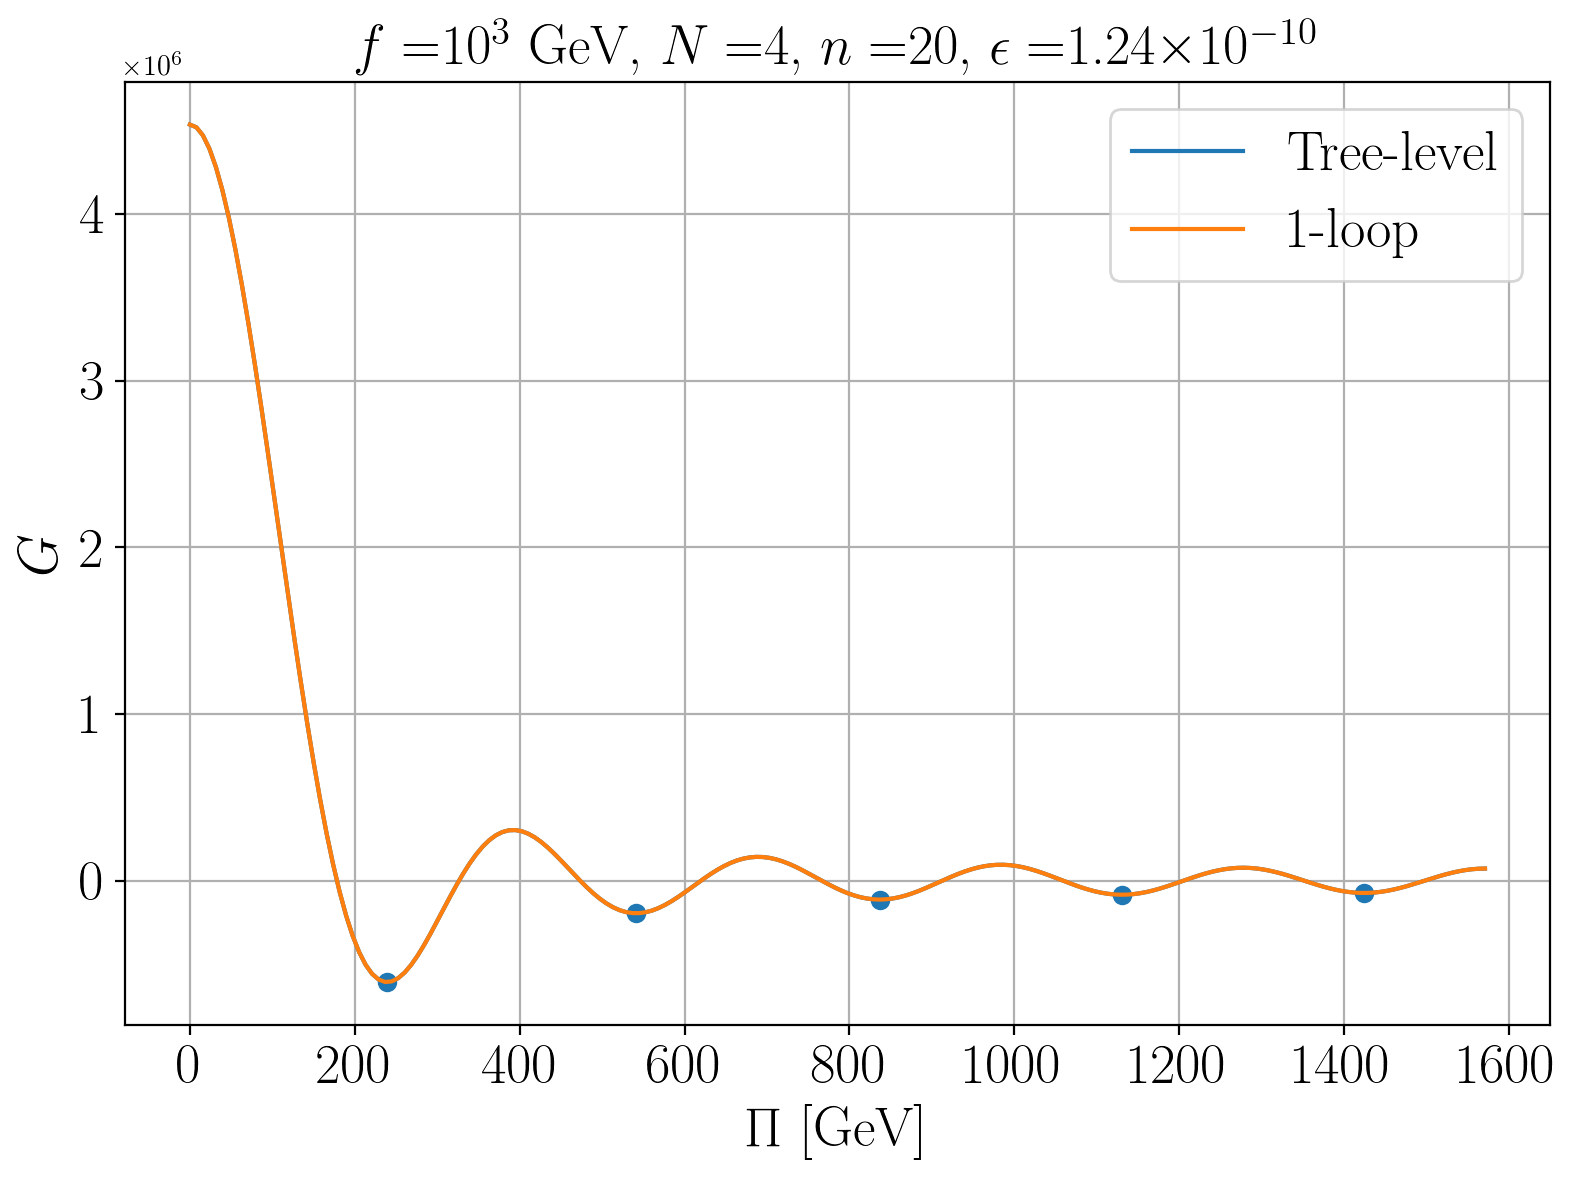

In [8]:
z_range=np.linspace(0,m.f*np.pi/2,200)

m.plot1()
plt.plot(z_range,m.Vtot(z_range,0),label="1-loop")
plt.legend(prop={'size': label_size})

plt.title("$f=$"+"$10^{"+str(round(np.log10(m.f)))+"}$"+" GeV"+ ", $N=$"+str(m.N)+
          ", $n=$"+str(m.n)+", $\epsilon=$"+str(round(m.eps*10**(-np.round(np.log10(m.eps))),2))
          +"$\\times 10^{-"+str(-int(np.round(np.log10(m.eps))))+"}$",size=label_size)
plt.tight_layout()
#plt.savefig('./PLOTS/Dark_Sector/inverted_potential.pdf', dpi=300)

In [9]:
print("Flipping temperature given by \n", m.Tf)

Flipping temperature given by 
 228.41609628806427


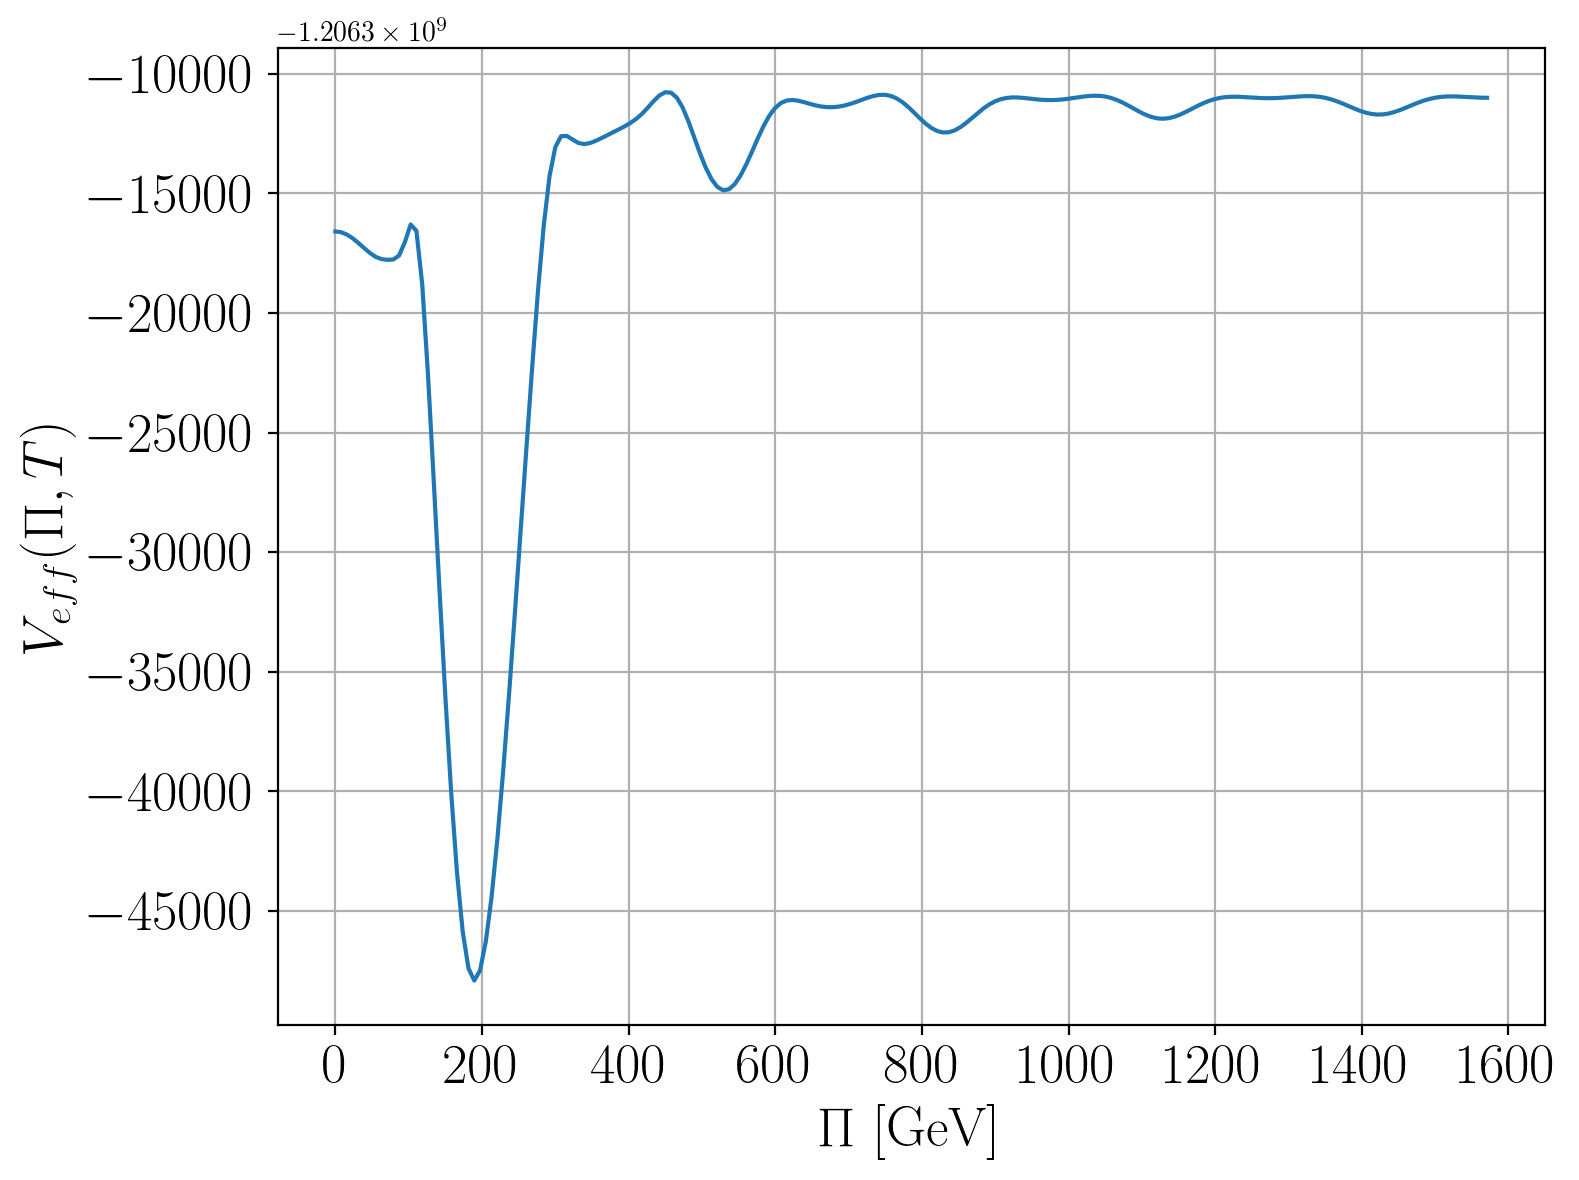

In [9]:
Temp=229
#Temp=m.Trestored-2
z_range=np.linspace(0,m.f*np.pi/2,200)

plt.plot(z_range,m.Vtot(z_range,Temp))


#plt.legend(prop={'size': label_size})
plt.xlabel("$\Pi$ [GeV]",size=label_size)
plt.ylabel("$V_{eff}(\\Pi,T)$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
#mytitle="T= "+str(np.round(T,1))+" GeV"
#plt.title(mytitle,size=label_size)
plt.tight_layout()
#plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
#plt.show()


In [10]:
m.findTrestoration()

328.4160962880643

In [11]:
m.minTracker()

{'phase_0': {'phi': [-8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.881784197001252e-16,
   -8.8817

In [12]:
m.findTcritical()

In [13]:
m.Tc

229.764679907809

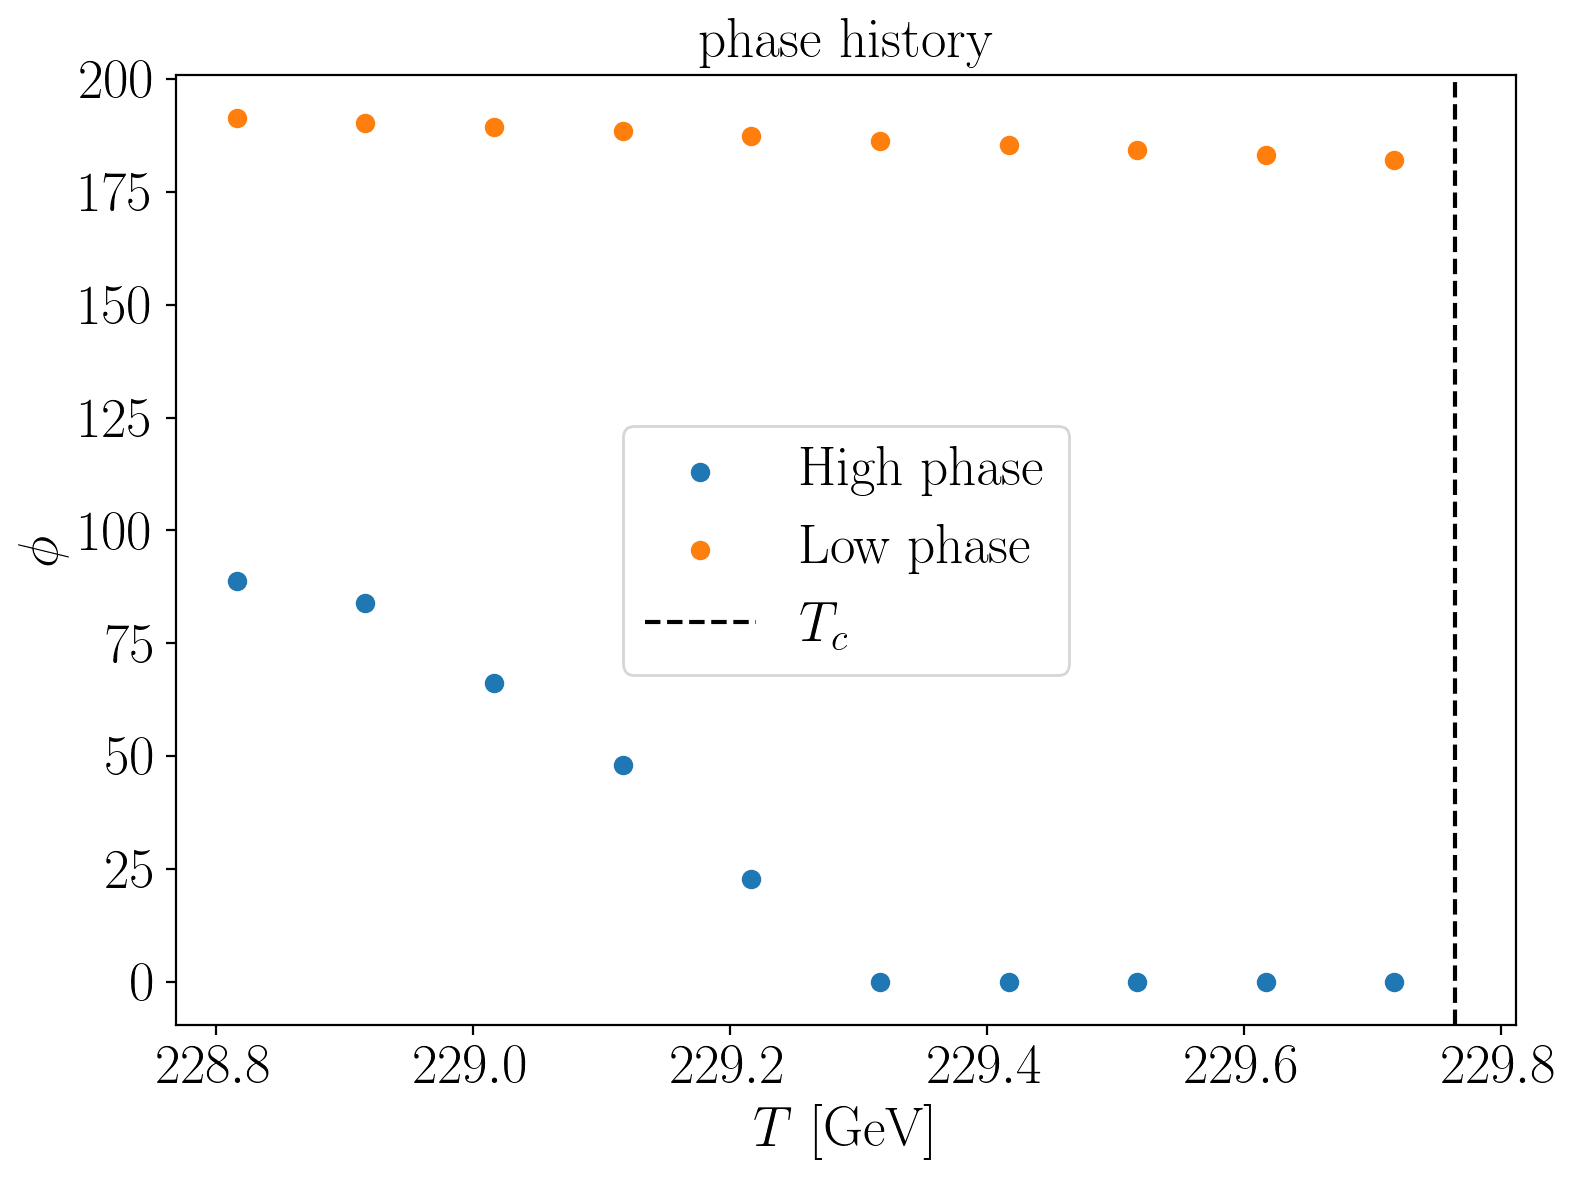

In [14]:
#plt.scatter(m.phases["phase_0"]["T"],m.phases["phase_0"]["phi"])
#plt.scatter(m.phases["phase_1"]["T"],m.phases["phase_1"]["phi"])
phase_output=m.phases

ind=np.where(np.array(phase_output["phase_0"]["T"])<=m.Tc)
plt.scatter(np.array(phase_output["phase_0"]["T"])[ind],np.array(phase_output["phase_0"]["phi"])[ind],label="High phase")

ind=np.where(np.array(phase_output["phase_1"]["T"])<=m.Tc)
plt.scatter(np.array(phase_output["phase_1"]["T"])[ind],np.array(phase_output["phase_1"]["phi"])[ind],label="Low phase")

plt.axvline(x=m.Tc,c="k",linestyle="--",label="$T_c$")

plt.xlabel("$T$ [GeV]",size=label_size)
plt.ylabel("$\\phi$",size=label_size)

plt.legend(prop={'size': label_size})

plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
#plt.grid(True)
mytitle="phase history"
plt.title(mytitle,size=label_size)
plt.tight_layout()

In [15]:
Tmin=min(m.phases["phase_0"]["T"])
nucleation_list=[]
for temp in np.linspace(Tmin,m.Tc):
    try:
        nuc_output=m.nucleation(temp)
        if len(nuc_output)!=0:
            nucleation_list.append(nuc_output)
    except:
        continue
df_nuc=pd.DataFrame(nucleation_list)


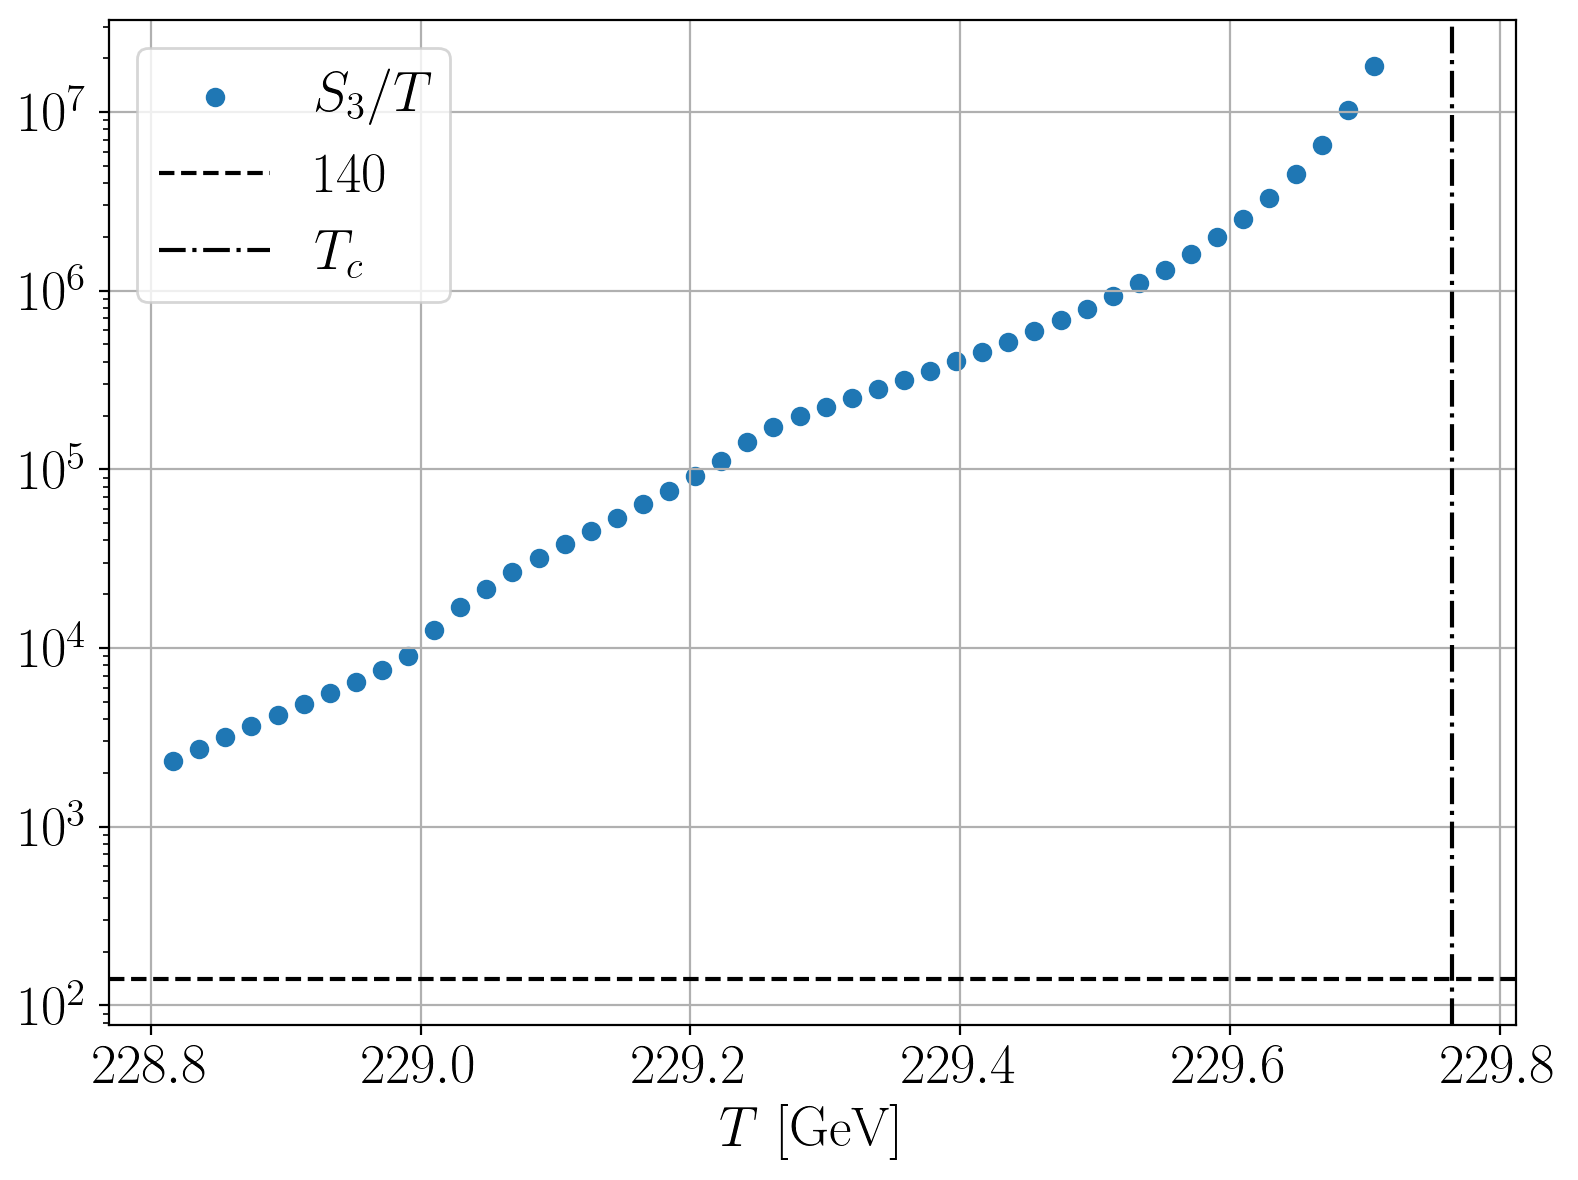

In [16]:


plt.scatter(df_nuc["Tn"],df_nuc["S_3"],label="$S_3/T$")
plt.yscale("log")
plt.axhline(y=140,c="k",linestyle="--",label="140")
plt.axvline(x=m.Tc,c="k",linestyle="-.",label="$T_c$")

plt.xlabel("$T$ [GeV]",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)

plt.grid(True)
plt.legend(prop={'size': label_size})



plt.tight_layout()
#plt.savefig('./PLOTS/Euclidean_action_1.pdf', dpi=300)
plt.show()

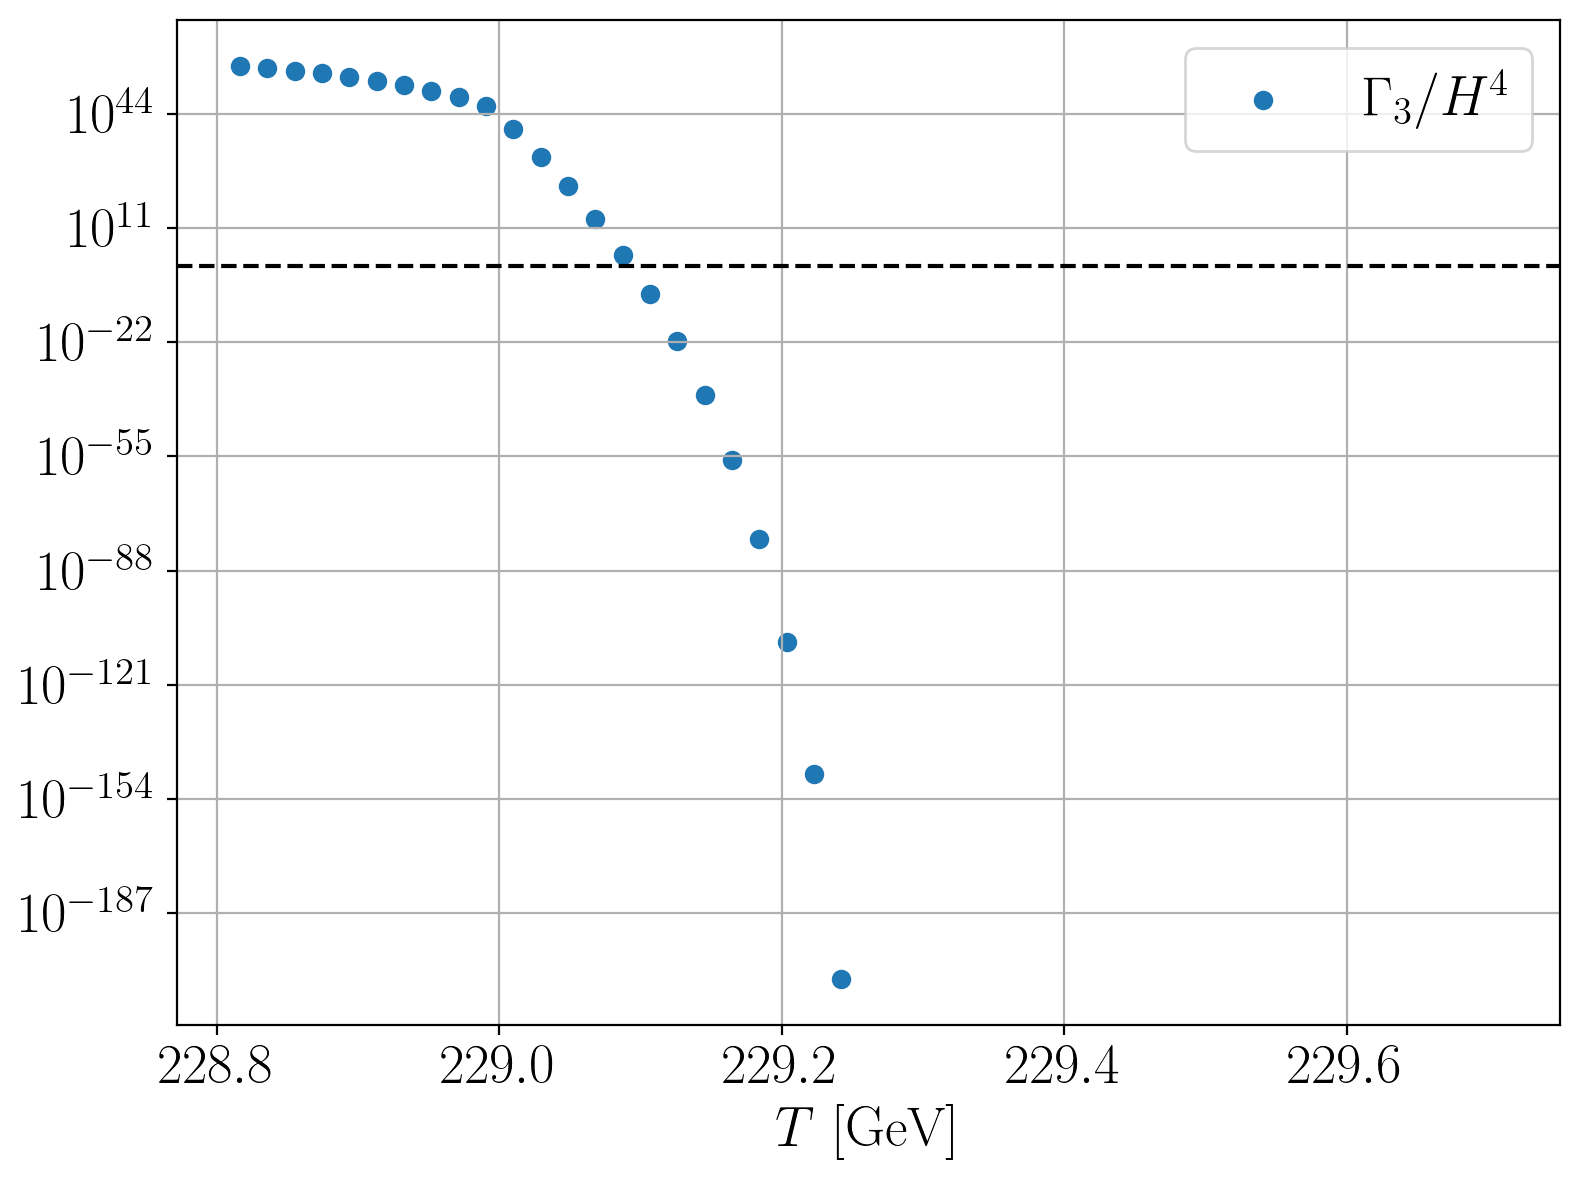

In [17]:
plt.scatter(df_nuc["Tn"],df_nuc["Gamma"]/(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2,label="$\Gamma_3/H^4$")
plt.axhline(y=1,c="k",linestyle="--")
plt.yscale("log")

plt.xlabel("$T$ [GeV]",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend(prop={'size': label_size})
#mytitle="Effective potential at T= "+str(T)+" GeV"
#plt.title(mytitle,size=label_size)
plt.tight_layout()
#plt.savefig('./PLOTS/Rates_1.pdf', dpi=300)
plt.show()

In [5]:
m.thermodynamics()

{'Ngb': 4,
 'n': 20,
 'epsilon': 1.2437235612689684e-10,
 'f': 1000,
 'Tf': 228.41609628806427,
 'Trestored': 328.4160962880643,
 'Tc': 229.764679907809,
 'phi_false': 52.68741641934958,
 'phi_true': 188.69981911341864,
 'Tn': 229.08740617987195,
 'alpha': 0.002242939894573731,
 'beta': 296292.080999061,
 'vw': 0.05784702172954982,
 'SNR': 3.142489806104152e-19,
 'xi_0': 1.0,
 'xi_nuc': 1.0029389780436535}

In [4]:
%%time
##Do a scan over polynomial order n
n_range=np.arange(10,60,3)
all_results=[]
for n_val in n_range:
    try:        
        Ngb_val=4
        #n_val=20
        f_val=1000
        Mscale_val=4*np.pi*f_val
        epsilon_val=epsilon_bound(f_val,Mscale_val,n_val,Ngb_val)
        epsilon_valT=epsilon_boundT(f_val,Mscale_val,n_val,Ngb_val)
        #m=model1( N =Ngb_val, n=n_val , f=f_val, eps=epsilon_valT*1e-1)
        m=model1( N =Ngb_val, n=n_val , f=f_val, eps=epsilon_valT*1e-2,xi=2)
        dict_out=m.thermodynamics()
        all_results.append(dict_out)
    except:
        continue

CPU times: user 5min 25s, sys: 1.72 s, total: 5min 27s
Wall time: 5min 28s


In [27]:
#pd.DataFrame(all_results).to_csv("./SCANS_DS_PT/coolsDS_normalPT_Tv_equal_2Tf.csv")



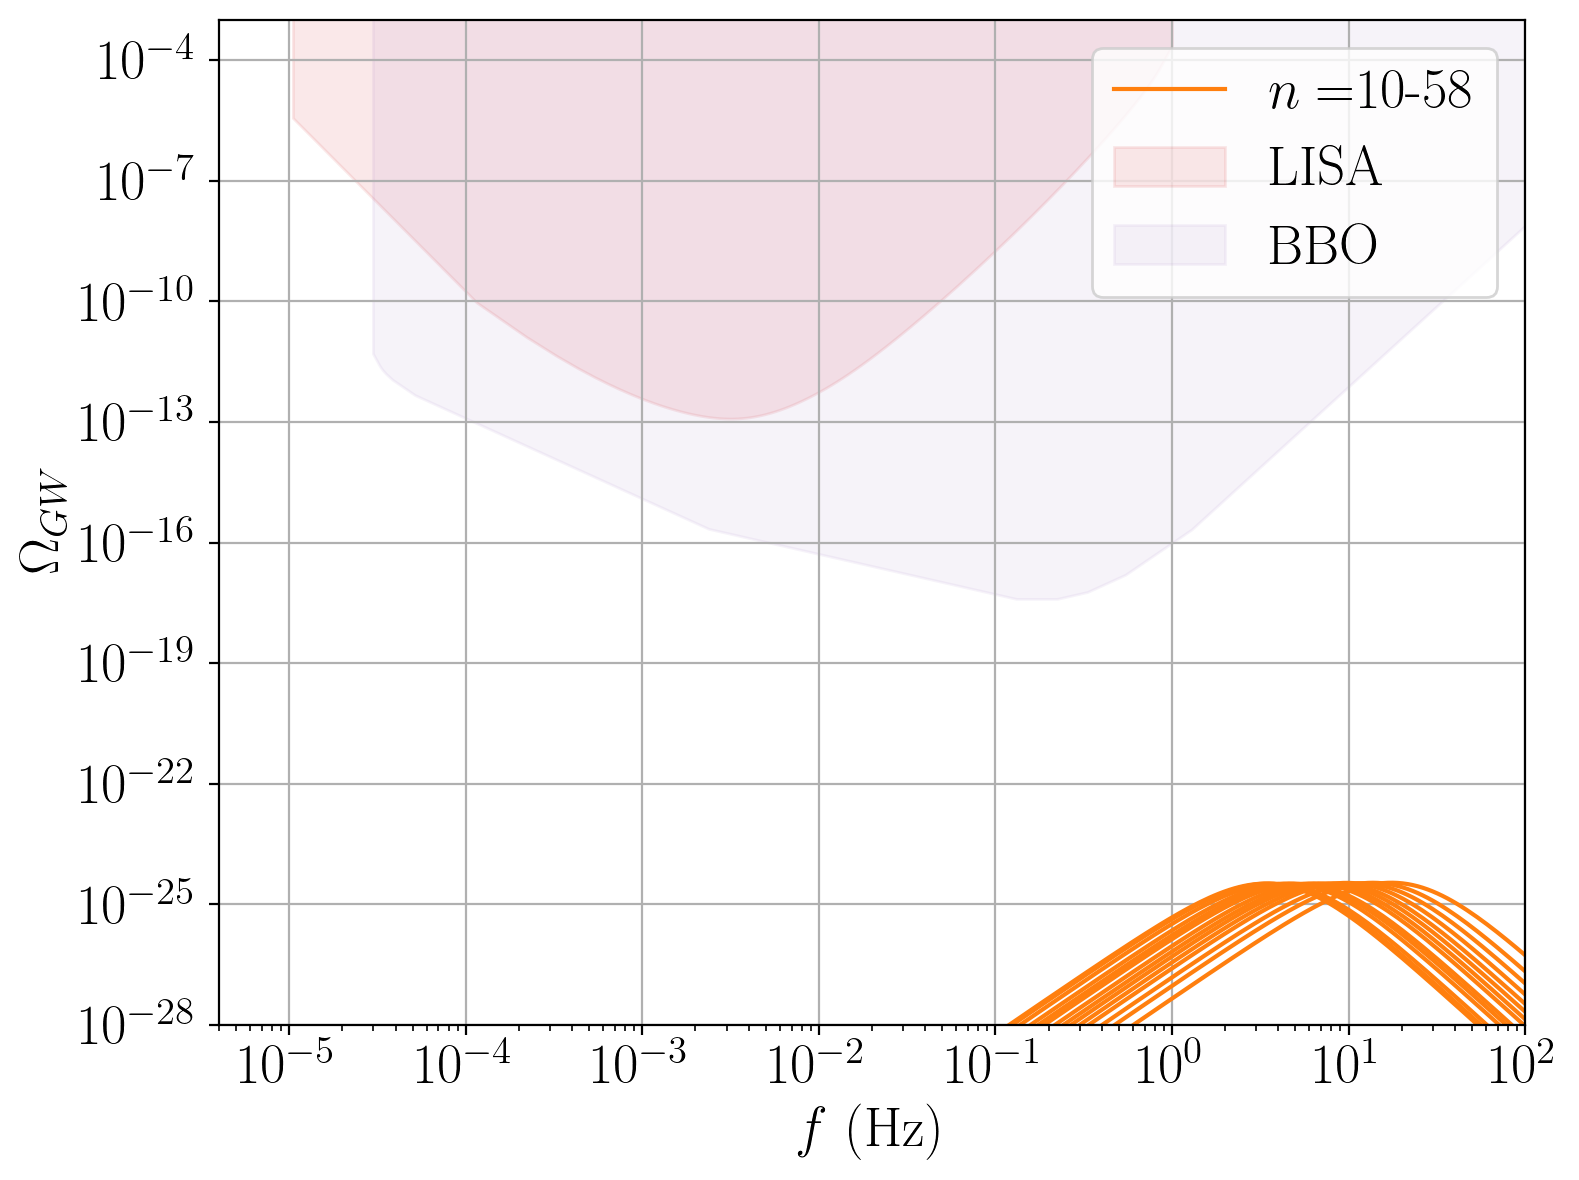

In [23]:
df_out=pd.read_csv("./SCANS_DS_PT/coolsDS_normalPT_Tv_equal_2Tf.csv",index_col=[0]).sort_values("alpha",ascending=False)

for modi in range(len(df_out)):
    Temp=df_out.iloc[modi].Tn
    alpha=df_out.iloc[modi].alpha
    beta=df_out.iloc[modi].beta
    gdof=df_out.iloc[modi].gdof
    vel=1
    my_signal=GW_signal(Temp,alpha,beta,vel,gdof)
    mylabel=""
    if modi==len(df_out)-1:
        mylabel="$n=$"+str(int(df_out.n.min()))+"-"+str(int(df_out.n.max()))
    #plt.plot(my_signal[0],my_signal[1],label="$n=$"+str(int(df_out.iloc[modi].n)))
    plt.plot(my_signal[0],my_signal[1],label=mylabel,color="#ff7f0e")

plt.fill_between(LISA_sens[::,0],LISA_sens[::,3], 1e-2, alpha=0.1,color="#d62728",label="LISA")
plt.fill_between(BBO_sens["f"],BBO_sens["Omega_lim"], 1e-2, alpha=0.08,color="#9467bd",label="BBO")
plt.legend(prop={'size': label_size})



#plt.plot(LISA_curve.f,LISA_curve.Omega_lim,alpha=0.05,color="g")
#plt.figtext(.4, .72, "LISA", fontsize=label_size)
plt.ylim(1e-28,1e-3)
plt.xlim(10**(-5.4),100)
#plt.title("$n_1=$"+str(int(n1))+", $a_1=$"+str(np.round(a1,3))+", $n_2=$"+str(int(n2))+", $a_2=$"+str(np.round(a2,3)),size=label_size)
plt.xlabel("$f$ (Hz)",size=label_size)
plt.ylabel("$\\Omega_{GW}$",size=label_size)
plt.xscale("log")
plt.yscale("log")  
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.tight_layout()
#plt.savefig('./PLOTS/Dark_Sector/GW_cool_DS_normal_PT_Tv_equal_2Tf.pdf', dpi=300)

In [25]:
%%time
##Do a scan over visible sector temperature Tv=xi*Tf
xi_range=np.arange(2,10,2)
all_results=[]
for xi_val in xi_range:
    try:        
        Ngb_val=4
        n_val=20
        f_val=1000
        Mscale_val=4*np.pi*f_val
        epsilon_val=epsilon_bound(f_val,Mscale_val,n_val,Ngb_val)
        epsilon_valT=epsilon_boundT(f_val,Mscale_val,n_val,Ngb_val)
        #m=model1( N =Ngb_val, n=n_val , f=f_val, eps=epsilon_valT*1e-1)
        m=model1( N =Ngb_val, n=n_val , f=f_val, eps=epsilon_valT*1e-2,xi=xi_val)
        dict_out=m.thermodynamics()
        all_results.append(dict_out)
    except:
        continue

CPU times: user 1min 16s, sys: 325 ms, total: 1min 16s
Wall time: 1min 17s


In [29]:
#pd.DataFrame(all_results).to_csv("./SCANS_DS_PT/coolsDS_normalPT_n_equal_20.csv")


df_out=pd.read_csv("./SCANS_DS_PT/coolsDS_normalPT_n_equal_20.csv",index_col=[0]).sort_values("alpha",ascending=False)
df_out

,Ngb,n,epsilon,f,Tf,Trestored,Tc,phi_false,phi_true,Tn,alpha,beta,vw,SNR,xi_0,xi_nuc,gdof
0,4,20,1.243724e-10,1000,228.416096,328.416096,229.76468,52.687416,188.699819,229.087406,0.002243,296292.080200,0.057847,3.214234e-20,0.500000,0.501469,1650.899410
1,4,20,1.243724e-10,1000,228.416096,328.416096,229.76468,55.661126,188.887977,229.068494,0.002204,276284.401219,0.059078,4.461428e-21,0.250000,0.250714,26368.840688
2,4,20,1.243724e-10,1000,228.416096,328.416096,229.76468,55.727427,188.892172,229.068073,0.002203,274764.718291,0.059105,1.186565e-21,0.166667,0.167142,133498.223083
3,4,20,1.243724e-10,1000,228.416096,328.416096,229.76468,55.729850,188.892325,229.068057,0.002203,274709.230447,0.059106,4.552253e-22,0.125000,0.125357,421963.258533


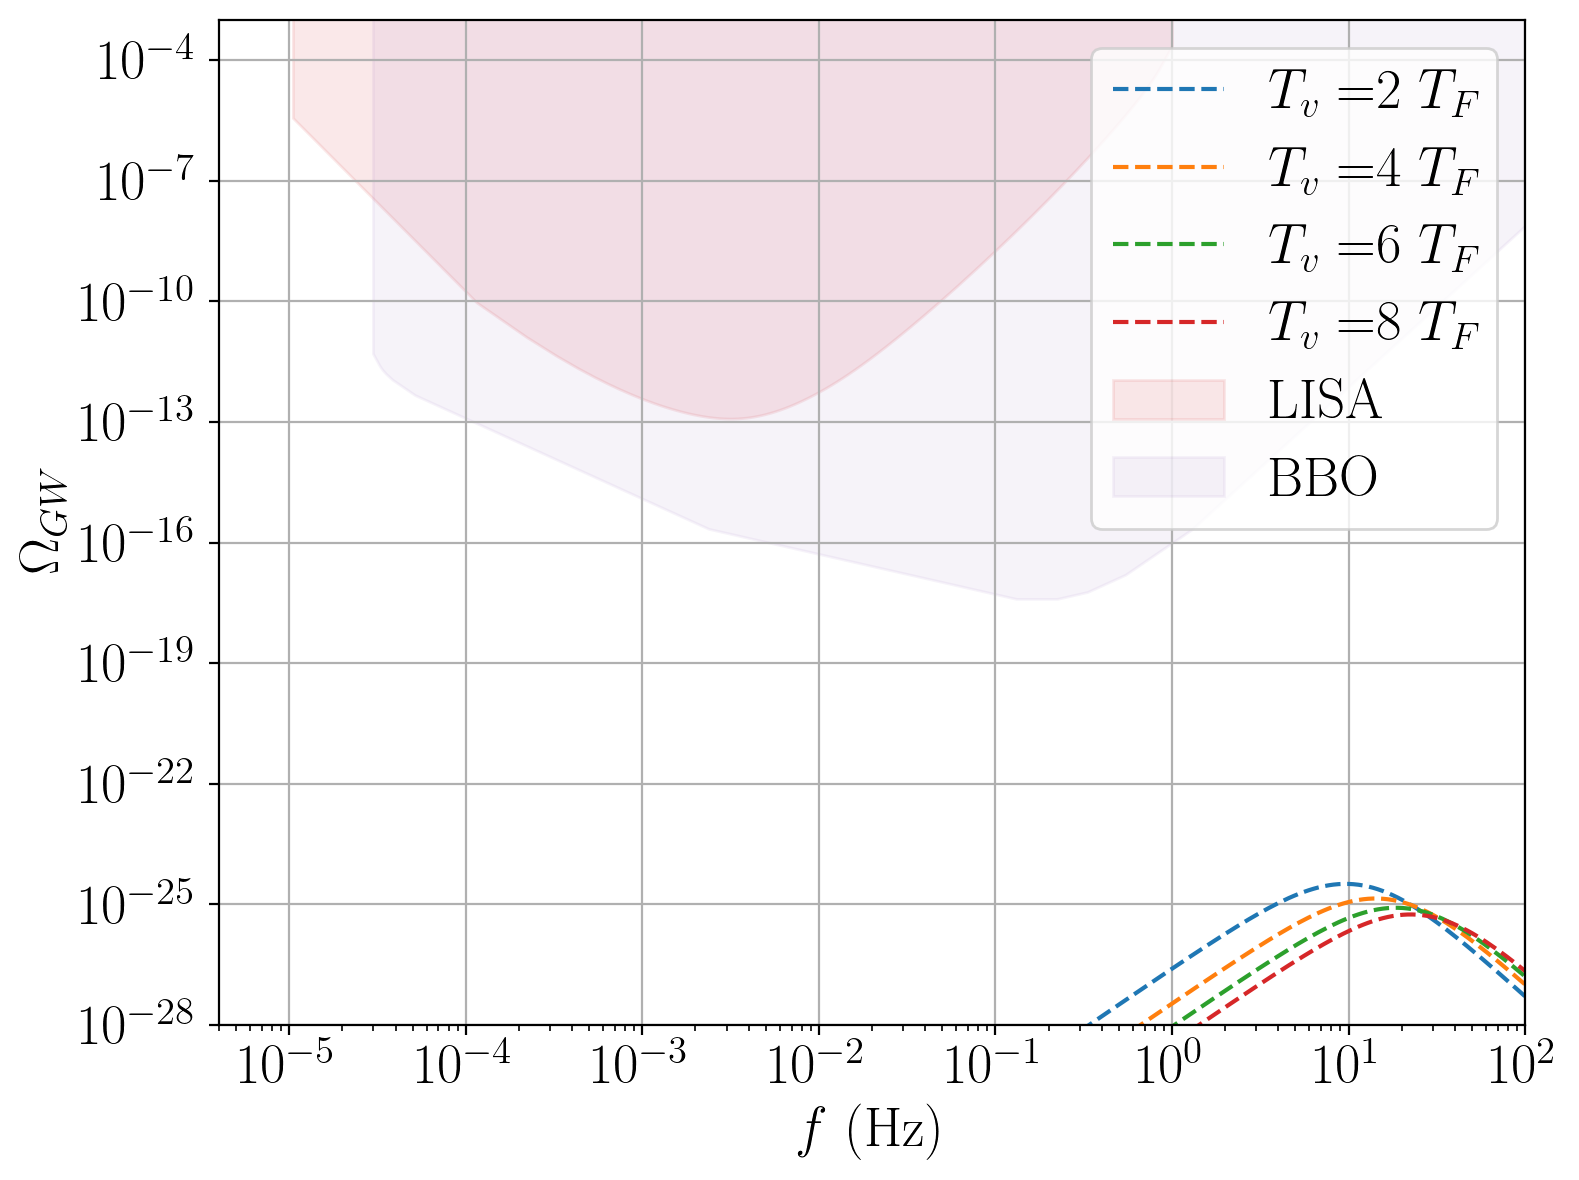

In [56]:
df_out=pd.read_csv("./SCANS_DS_PT/coolsDS_normalPT_n_equal_20.csv",index_col=[0]).sort_values("alpha",ascending=False)

for modi in range(len(df_out)):
    Temp=df_out.iloc[modi].Tn
    alpha=df_out.iloc[modi].alpha
    beta=df_out.iloc[modi].beta
    gdof=df_out.iloc[modi].gdof
    vel=1
    my_signal=GW_signal(Temp,alpha,beta,vel,gdof)
    mylabel="$T_v=$"+str(int(1/df_out.iloc[modi].xi_0))+"\ $T_F$"
    plt.plot(my_signal[0],my_signal[1],label=mylabel,linestyle="--")

plt.fill_between(LISA_sens[::,0],LISA_sens[::,3], 1e-2, alpha=0.1,color="#d62728",label="LISA")
plt.fill_between(BBO_sens["f"],BBO_sens["Omega_lim"], 1e-2, alpha=0.08,color="#9467bd",label="BBO")
plt.legend(prop={'size': label_size})



#plt.plot(LISA_curve.f,LISA_curve.Omega_lim,alpha=0.05,color="g")
#plt.figtext(.4, .72, "LISA", fontsize=label_size)
plt.ylim(1e-28,1e-3)
plt.xlim(10**(-5.4),100)
#plt.title("$n_1=$"+str(int(n1))+", $a_1=$"+str(np.round(a1,3))+", $n_2=$"+str(int(n2))+", $a_2=$"+str(np.round(a2,3)),size=label_size)
plt.xlabel("$f$ (Hz)",size=label_size)
plt.ylabel("$\\Omega_{GW}$",size=label_size)
plt.xscale("log")
plt.yscale("log")  
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.tight_layout()
#plt.savefig('./PLOTS/Dark_Sector/GW_cool_DS_normal_PT_n_equal_20.pdf', dpi=300)

In [60]:
df1=pd.read_csv("./SCANS_DS_PT/coolsDS_normalPT_n_equal_20.csv",index_col=[0]).sort_values("alpha",ascending=False)
print(df1.alpha.mean(),df1.beta.mean())

df2=pd.read_csv("./SCANS_DS_PT/coolsDS_normalPT_Tv_equal_2Tf.csv",index_col=[0]).sort_values("alpha",ascending=False)

print(df2.alpha.mean(),df2.beta.mean())

0.00221298693777755 280512.60753939324
0.0022311874602068712 290170.1450255791
